Introduce the idea
- give background on JBP + CN interview
- explain general media angle towards JBP
- present question of: are his followers angry evil bigots or just normal people

introduce method
- using semantic analysis tools on millions of comments across dozens of youtube videos involving his audience
- looking at sentiment polarity
- looking at moodtags

As online communities have gained traction in the 'real world', journalists have worked to understand and explain them. So far, their attempts have come up short.

The typical method is to cover an online community the same way you'd cover a mass political movement. Understandably so — both can consist of millions of people, united by some common thread and therefore all doing something together. A rally and an online community, however, are profoundly different. The rally is a simple creature: everyone attending supports some stated mission, and they show that support in a singular way — marching.

Online communities, however, present a massively more complex problem. Rather than marching as one behind the banner of a cause, online communities are decentralized and spontaneous. As a 'member' — if that label even applies — you are individual with your own voice. You attend if and when you please, engage in whichever way you see fit, and are not required to march in anyone's parade.

An online community, with all of its fractious diversity and subtle details, cannot be adequately explained by the language of political movements. A high resolution photo should not be viewed on a low resolution screen.

Nowhere has this been more evident than in the critical news coverage of Jordan Peterson's rise to international fame.

[Many]() [articles]() [have]() [categorized]() Dr. Peterson's audience as a horde of angry white men, who will 

Of course, this is applying a standard political lens to Peterson's _movement_ (if we can call it that), and building on that. Peterson's message is interpreted by the left-leaning journalist as reactionary against modern third-wave (for those of you counting at home) feminism. They then see that it attracts white men. They infer that, since it is a reactionary movement of white men, that these men are struggling back against the social gains of other classes — and are therefore angry.

Then, they see angry comments on YouTube and Twitter, and their ideological suppositions are confirmed. _Jordan Peterson is the lord of the angry white men._



Using some basic natural language processing and data analysis, I'm going to see if the comments prove (or falsify) that hypothesis. My methods are 

In [1]:
import pandas as pd
import numpy as np
from senticnet.senticnet import SenticNet
import spacy
import re, string
import math
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import tools.similarityscores

sn = SenticNet()
nlp = spacy.load('en')

We're going to use Pandas and Numpy for our basic data processing and analysis, matplotlib for simple visualizations, SenticNet for our semantic analysis, and spaCy for some of its basic NLP tools.

To get started, let's pull in our datasets. We're looking at scraped comments from various YouTube videos:
- Newman interview
- All of Peterson's biblical lectures, combined into one
- The Munk debate
- The first presidential debate
- A random music video by the chainsmokers

In [2]:
# Create metadata to track CSV files before they're read into a dataframe

video_list = [
    {'Video Title': 'Peterson vs Newman', 'Path': './comment-assets/newman-new.csv', 'JBP': True, 'Debate': True, 'Genre': 'Intellectual'},
    {'Video Title': 'Biblical Lectures (Peterson)', 'Path': './comment-assets/biblical-lectures.csv', 'JBP': True, 'Debate': False, 'Genre': 'Intellectual'},
    {'Video Title': 'Munk Debate (Peterson, Fry, Dyson, Goldberg)', 'Path': './comment-assets/munk-debate.csv', 'JBP': True, 'Debate': True, 'Genre': 'Intellectual'},
    {'Video Title': 'Personality Lectures (Peterson)', 'Path': './comment-assets/personality-lectures.csv', 'JBP': True, 'Debate': False, 'Genre': 'Intellectual'},
    {'Video Title': 'Peterson on Rogan', 'Path': './comment-assets/peterson-rogan.csv', 'JBP': True, 'Debate': False, 'Genre': 'Intellectual'},
    {'Video Title': 'Peterson on Maher', 'Path': './comment-assets/peterson-maher.csv', 'JBP': True, 'Debate': False, 'Genre': 'Intellectual'},
    {'Video Title': 'PewDiePie Soyboys', 'Path': './comment-assets/pewdiepie-soyboys.csv', 'JBP': False, 'Debate': False, 'Genre': 'Popular'},
    {'Video Title': 'Chainsmokers Music Video', 'Path': './comment-assets/chainsmokers.csv', 'JBP': False, 'Debate': False, 'Genre': 'Popular'},
    {'Video Title': 'Clinton vs Trump Debate', 'Path': './comment-assets/clinton-trump.csv', 'JBP': False, 'Debate': True, 'Genre': 'Intellectual'},
    {'Video Title': 'Obama vs Romney Debate', 'Path': './comment-assets/obama-romney.csv', 'JBP': False, 'Debate': True, 'Genre': 'Intellectual'},
    {'Video Title': 'Hitchens vs Ramadan Debate', 'Path': './comment-assets/hitchens-ramadan.csv', 'JBP': False, 'Debate': True, 'Genre': 'Intellectual'},
    {'Video Title': 'TED Talk Sam Harris', 'Path': './comment-assets/ted-talk-harris.csv', 'JBP': False, 'Debate': False, 'Genre': 'Intellectual'},
    {'Video Title': 'TED Talk James Veitch', 'Path': './comment-assets/ted-talk-veitch.csv', 'JBP': False, 'Debate': False, 'Genre': 'Intellectual'},
    {'Video Title': 'TED Talk Cameron Russell', 'Path': './comment-assets/ted-talk-russell.csv', 'JBP': False, 'Debate': False, 'Genre': 'Intellectual'},
    {'Video Title': 'TED Talk Amy Cuddy', 'Path': './comment-assets/ted-talk-cuddy.csv', 'JBP': False, 'Debate': False, 'Genre': 'Intellectual'},
    {'Video Title': 'Makeup Under a Microscope', 'Path': './comment-assets/makeup-microscrope.csv', 'JBP': False, 'Debate': False, 'Genre': 'Popular'},
    {'Video Title': 'Metallica Music Video', 'Path': './comment-assets/metallica-nothing-else-matters.csv', 'JBP': False, 'Debate': False, 'Genre': 'Popular'},
    {'Video Title': 'Drake Music Video', 'Path': './comment-assets/drake-nice-for-what.csv', 'JBP': False, 'Debate': False, 'Genre': 'Popular'},
]
metadataframe = pd.DataFrame(video_list)

In [3]:
comments = pd.DataFrame()

# Build a comments dataframe by pulling data from files listed in the metadata entered above
for idx, video in metadataframe.iterrows():
    df = pd.read_csv(video['Path'], error_bad_lines=False)
    df['Video Title'] = video['Video Title']
    df['JBP'] = video['JBP']
    df['Debate'] = video['Debate']
    df['Genre'] = video['Genre']
    comments = comments.append(df, ignore_index=True)

b'Skipping line 675: expected 4 fields, saw 7\nSkipping line 1349: expected 4 fields, saw 7\nSkipping line 2003: expected 4 fields, saw 7\nSkipping line 3086: expected 4 fields, saw 7\nSkipping line 3512: expected 4 fields, saw 7\nSkipping line 4132: expected 4 fields, saw 7\nSkipping line 4676: expected 4 fields, saw 7\nSkipping line 5468: expected 4 fields, saw 7\nSkipping line 6616: expected 4 fields, saw 7\nSkipping line 7912: expected 4 fields, saw 7\nSkipping line 8580: expected 4 fields, saw 7\nSkipping line 9316: expected 4 fields, saw 7\nSkipping line 12769: expected 4 fields, saw 7\nSkipping line 13225: expected 4 fields, saw 7\nSkipping line 14557: expected 4 fields, saw 7\nSkipping line 15291: expected 4 fields, saw 7\n'
b'Skipping line 146: expected 4 fields, saw 7\nSkipping line 674: expected 4 fields, saw 7\nSkipping line 704: expected 4 fields, saw 7\nSkipping line 1138: expected 4 fields, saw 7\nSkipping line 1214: expected 4 fields, saw 7\nSkipping line 1420: expected

Next, we're going to put together some functions to perform semantic analysis on these comments. To start, we'll clean the data by removing punctuation, splitting comments into lists of individual words (tokenizing), and dropping stopwords such as "the", "this", and "and".

In [4]:
def comment_cleaner(df):
    clean_comments = []    
    punct = str.maketrans(string.punctuation,' '*len(string.punctuation))
    for idx, comment in df.iterrows():
        cleaned = str(comment['commentText']).translate(punct)
        clean_comments.append(cleaned.lower().replace('\n', ' ').replace('\r', '').split(' '))
    return pd.Series(clean_comments)

In [5]:
def remove_stopwords(column):
    for comment in column:
        comment[:] = [x for x in comment if not nlp.vocab[str(x)].is_stop]
    return column

After scrubbing out all of our unnecessary stopwords and punctuation, we can use SenticNet to get the _polarity_ of each comment. Polarity tells us whether the tone of a comment is positive or negative. Here's a brief example:

In [6]:
print('Good polarity: ', sn.polarity_intense('good'))
print('Love polarity: ', sn.polarity_intense('love'))
print('Hate polarity: ', sn.polarity_intense('hate'))
print('Evil polarity: ', sn.polarity_intense('evil'))

Good polarity:  0.849
Love polarity:  0.83
Hate polarity:  -0.83
Evil polarity:  -0.76


The function below takes a comment as a parameter and finds the polarity of each word in the comment. Then, it takes the mean of all nonzero polarities — polarities of 0.0 are typically triggered by typos or proper nouns, which we do not want to skew our average.

The complete set of comment polarity scores will allow us to see the full distribution of commenters' tones.

In [7]:
def get_polarity(comment):
    comment_polarity = []
    for word in comment:
        token_polarity = 0.0
        try:
            token_polarity = float(sn.polarity_intense(str(word)))
        except Exception as e:
            pass
        comment_polarity.append(token_polarity)
    return np.mean([item for item in comment_polarity if (item != 0)])

To get more granular than mere positive-versus-negative, we're going to use SenticNet's _moodtags_: 'admiration', 'interest', 'joy', 'surprise', 'anger', 'sadness', 'fear', and 'disgust'. Each word analyzed will generate two moodtags, and each comment will have its own list of all of the moodtags generated.

In [8]:
print('Good moodtags: ', sn.moodtags('good'))
print('Love moodtags: ', sn.moodtags('love'))
print('Hate moodtags: ', sn.moodtags('hate'))
print('Evil moodtags: ', sn.moodtags('evil'))

Good moodtags:  ['#joy', '#interest']
Love moodtags:  ['#joy', '#admiration']
Hate moodtags:  ['#anger', '#disgust']
Evil moodtags:  ['#fear', '#disgust']


In the final analysis, we will be able to use this data to visualize the prevalence of certain moods, such as anger, among Jordan Peterson's commenters compared to commenters among other YouTube populations.

The following function assigns a list of moodtags to each comment in the dataframe.

In [9]:
def get_moodtags(comment):
    comment_moods = []
    for word in comment:
        try:
            comment_moods.append(sn.moodtags(str(word)))
        except Exception as e:
            pass
    return [item.strip('#') for sublist in comment_moods for item in sublist]

Let's run all of the comments through these functions.

In [10]:
comments['Cleaned'] = remove_stopwords(comment_cleaner(comments))
print('Comments cleaned.')
comments['Polarity'] = comments['Cleaned'].apply(get_polarity)
print('Polarities identified.')
comments['Moodtags'] = comments['Cleaned'].apply(get_moodtags)
print('Moodtags added.')
print(len(comments), 'comments processed.')

Comments cleaned.


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Polarities identified.
Moodtags added.
294036 comments processed.


Now, let's grab the specific pieces of data we're going to compare:
- Peterson's interview with Newman
- All of Peterson's debates (or combative interviews, including the one with Newman)
- The above, but sans Newman
- Peterson's lectures, to see if his audience behaves differently outside debates
- Intellectual debate videos that do not involve Peterson
- Intellectual lecture/instructional (non-debate) videos that do not involve Peterson (primarily TED talks)
- A group of popular, non-intellectual videos (music videos, PewDiePie, makeup tutorials, etc.)

In [11]:
newman_interview = comments.loc[(comments['Video Title']=='Peterson vs Newman')]
peterson_debates = comments.loc[(comments['JBP']==True) & (comments['Debate']==True)]
peterson_debates_sans_newman = comments.loc[(comments['Debate']==True) & (comments['JBP']==True) & (comments['Video Title']!='Peterson vs Newman')]
peterson_biblical_lectures = comments.loc[(comments['JBP']==True) & (comments['Debate']==False)]
intellectual_debates_sans_peterson = comments.loc[(comments['Debate']==True) & (comments['JBP']==False) & (comments['Genre']=='Intellectual')]
intellectual_sans_peterson = comments.loc[(comments['Debate']==False) & (comments['JBP']==False) & (comments['Genre']=='Intellectual')]
popular_videos = comments.loc[(comments['Genre']=='Popular')]

Everything is ready to go. Let's get started with our analysis.

Each of these comment groupings has a distribution of polarities. We're going to run the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) to check if these distributions are significantly different.  Essentially, KS tests the null hypothesis that two independent samples are drawn from the same distribution. A high KS statistic or low p-value would allow us to reject the null hypothesis.

In [12]:
# Comparing Peterson's Newman interv
print('Baseline: ', scipy.stats.ks_2samp(newman_interview['Polarity'], newman_interview['Polarity']))

Baseline:  Ks_2sampResult(statistic=0.0, pvalue=1.0)


The null hypothesis will show a _p-value_ of 1.0 and a statistic of 0.0. What do some real examples show?

In [13]:
# Comparing Peterson's Newman interview with his other debates
print(scipy.stats.ks_2samp(newman_interview['Polarity'], peterson_debates_sans_newman['Polarity']))

# Comparing all Jordan Peterson videos to all others
print(scipy.stats.ks_2samp(comments.loc[(comments['JBP']==True)]['Polarity'], comments.loc[(comments['JBP']==False)]['Polarity']))

# Comparing all Jordan Peterson debates with other debates
print(scipy.stats.ks_2samp(intellectual_debates_sans_peterson['Polarity'], peterson_debates['Polarity']))

Ks_2sampResult(statistic=0.09469526700989706, pvalue=1.229212074140142e-122)
Ks_2sampResult(statistic=0.19655750279728734, pvalue=0.0)
Ks_2sampResult(statistic=0.1098267413417417, pvalue=4.925503926430389e-237)


Across categories, we see significant differences in the polarity distributions — our first two p-values are well below 0.01 (note the scientific notation). We know these samples aren't drawn from the same distribution.

Next, we'll generate similarity scores for every comment set. We're looking to see which sets of comments are most similar (or different) and hoping to find a pattern. Step 1: build a [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) for each set of comments, so our data isn't skewed by the amount of comments per video.

In [14]:
polarity_dataframe = pd.DataFrame()
bins = 100

# Split the distribution for each set of comments' polarities into 100 bins
for title in comments['Video Title'].unique():
    pol = comments.loc[comments['Video Title']==title]['Polarity']
    hist = np.histogram(pol.dropna(), bins=bins)
    polarity_dataframe[title] = hist[0]

# Divide each row by the sum of the entire column, then save the dataframe
beta = polarity_dataframe.sum(axis=0)
polarity_dataframe = polarity_dataframe.apply(lambda row: row / beta, axis=1)

Now let's build a new dataframe that will allow us to do a pairwise comparison of each video to every other video.

In [15]:
column_headers = list(polarity_dataframe)
pairwise_list = []

# Nested loops round-robin through our columns, creating a pairwise comparison
for i in range(len(column_headers)):
    for j in range(i+1, len(column_headers)):
        pairwise_list.append({'Video 1': column_headers[i], 'Video 2': column_headers[j]})

# Create new dataframe from list of dicts
pairwise_comparison = pd.DataFrame(pairwise_list)

Now that we have our pairwise comparisons set up, let's run some similarity scores: Euclidean Distance, Manhattan Distance, and Cosine Similarity. We'll add each of those to the dataframe, and then sort them in that order.

In [16]:
from tools.similarityscores import Similarity
similarity = Similarity()

euclidean_distance = []
manhattan_distance = []
cosine_similarity = []

# Build lists of similarity scores for each pairwise comparison
for idx, row in pairwise_comparison.iterrows():
    vid1 = polarity_dataframe[row['Video 1']]
    vid2 = polarity_dataframe[row['Video 2']]
    euclidean_distance.append(similarity.euclidean_distance(vid1, vid2))
    manhattan_distance.append(similarity.manhattan_distance(vid1, vid2))
    cosine_similarity.append(similarity.cosine_similarity(vid1, vid2))

# Add columns from each list of similarity scores
pairwise_comparison['Euclidean Distance'] = euclidean_distance
pairwise_comparison['Manhattan Distance'] = manhattan_distance
pairwise_comparison['Cosine Similarity'] = cosine_similarity

pairwise_comparison.sort_values(by=['Euclidean Distance', 'Manhattan Distance',
                                    'Cosine Similarity'], ascending=[True, True, False])

,Video 1,Video 2,Euclidean Distance,Manhattan Distance,Cosine Similarity
57,Personality Lectures (Peterson),TED Talk Cameron Russell,0.020996,0.144837,0.993
35,"Munk Debate (Peterson, Fry, Dyson, Goldberg)",Peterson on Maher,0.021835,0.137678,0.992
18,Biblical Lectures (Peterson),Personality Lectures (Peterson),0.023899,0.150416,0.990
1,Peterson vs Newman,"Munk Debate (Peterson, Fry, Dyson, Goldberg)",0.024205,0.184197,0.983
28,Biblical Lectures (Peterson),TED Talk Cameron Russell,0.024470,0.171548,0.991
70,Peterson on Rogan,TED Talk Cameron Russell,0.024472,0.164843,0.990
48,Personality Lectures (Peterson),Peterson on Rogan,0.024681,0.154235,0.990
19,Biblical Lectures (Peterson),Peterson on Rogan,0.028806,0.193063,0.986
26,Biblical Lectures (Peterson),TED Talk Sam Harris,0.029629,0.201150,0.979
9,Peterson vs Newman,Hitchens vs Ramadan Debate,0.032581,0.224609,0.976


All of this makes intuitive sense. We're seeing pairings fall neatly into the genres of _intellectual_ versus _popular_, as well as intellectual's subgenres of _debate_ or _lecture/talk_. 

The most similar sets of comments are on Jordan Peterson's two most famous and acrimonious debates. The top group includes various pairings of intellectual lectures and debates. On the most-different end, we see presidential debates athwart music videos and PewDiePie looking quite different from Jordan Peterson's appearance on Real Time with Bill Maher.

Notably, we're not seeing a major difference (or lack of similarity) between Jordan Peterson's audience and other intellectual audiences — in fact, many of the most-similar comment sets are between Peterson's audience and TED Talks, major debates, and presidential debates.

Rather, the early indication is that comment tone is more dependent on video type than any particular YouTuber's audience. Let's visualize some of these comparisons to get a better sense of how different audiences and genres relate.

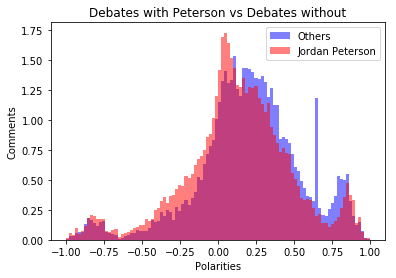

In [17]:
plt.hist(intellectual_debates_sans_peterson['Polarity'].dropna(), normed=True, color='blue', bins=100, alpha=.5, range=(-1, 1), label='Others')
plt.hist(peterson_debates['Polarity'].dropna(), normed=True, color='red', bins=100, alpha=.5, range=(-1, 1), label='Jordan Peterson')
plt.ylabel('Comments')
plt.xlabel('Polarities')
plt.title('Debates with Peterson vs Debates without')
plt.legend()
plt.show()

Both have similar shapes. Now let's look at all intellectual debates versus all intellectual lectures.

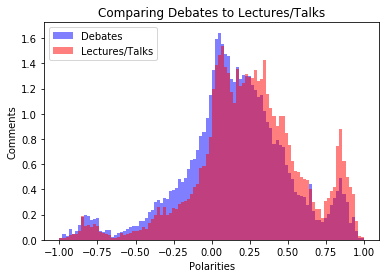

In [18]:
plt.hist(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==True)]['Polarity'].dropna(), normed=True, color='blue', bins=100, alpha=.5, range=(-1, 1), label='Debates')
plt.hist(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==False)]['Polarity'].dropna(), normed=True, color='red', bins=100, alpha=.5, range=(-1, 1), label='Lectures/Talks')
plt.ylabel('Comments')
plt.xlabel('Polarities')
plt.title('Comparing Debates to Lectures/Talks')
plt.legend()
plt.show()

Again, the curves share a similar shape. Let's compare overall intellectual videos to popular videos, to see if we can see why those were splitting so dramatically in the similarity scoring.

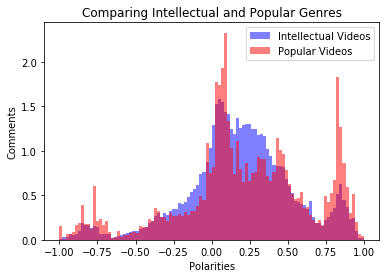

In [19]:
plt.hist(comments.loc[(comments['Genre']=='Intellectual')]['Polarity'].dropna(), normed=True, color='blue', bins=100, alpha=.5, range=(-1, 1), label='Intellectual Videos')
plt.hist(comments.loc[(comments['Genre']=='Popular')]['Polarity'].dropna(), normed=True, color='red', bins=100, alpha=.5, range=(-1, 1), label='Popular Videos')
plt.ylabel('Comments')
plt.xlabel('Polarities')
plt.title('Comparing Intellectual and Popular Genres')
plt.legend()
plt.show()

Clearly, differences between genre form the biggest split between audiences' tones in the comments.

Now that we've addressed tone and shown that Jordan Peterson's audience isn't abnormally negative (or abnormally _anything_, for that matter), let's move into SenticNet's moodtags to see if we can find some abnormalities there. Specifically, we're investigating the claim that Peterson's audience viciously berates anyone who challenges his arguments. To find that, we'll look for an overrepresentation of negative emotions — particularly anger — in Peterson's debates with others.

Pie charts are the simplest way to visualize a count of all of our moodtags. Let's get started.

In [50]:
# Setting up our pie charts for visual consistency
explode = (0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1)
labels = ['admiration', 'interest', 'joy', 'surprise', 'anger', 'sadness', 'fear', 'disgust']

# Creating a Counter object to count (duh) every moodtag in a given set of comments
def count_moodtags(df):
    word_string = ''
    word_list = [item for sublist in df['Moodtags'] for item in sublist]
    word_string += ', '.join(word_list)
    return Counter(word_list)

First, let's take a broad look at the combined comments on all of Jordan Peterson's videos:

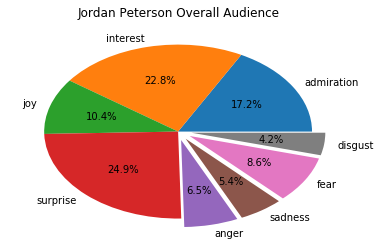

In [46]:
plt.pie(count_moodtags(comments.loc[comments['JBP']==True]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Jordan Peterson Overall Audience')
plt.show()

At first glance, this doesn't seem like a particularly angry group of people. Let's drill down and see if we can find where that 6.5% anger is coming from. Perhaps it's overrepresented in Peterson's interview with Cathy Newman on Channel 4; after all, the network claimed that the deluge of negative and threatening comments was so severe, they needed to bring in security experts.

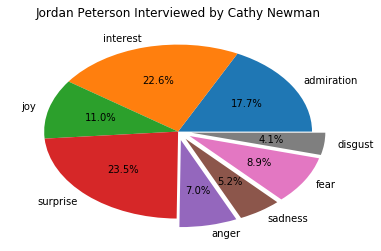

In [51]:
plt.pie(count_moodtags(newman_interview).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Jordan Peterson Interviewed by Cathy Newman')
plt.show()

Surprisingly, everything is right near the baseline. According to the data, a massive majority of Peterson's audience did not act angrily towards the Cathy Newman interview. Let's see if the response to all of his debates is different:

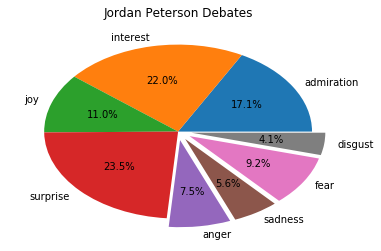

In [47]:
plt.pie(count_moodtags(comments.loc[(comments['Debate']==True) & comments['JBP']==True]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Jordan Peterson Debates')
plt.show()

Again, right near the baseline. The anger is a tad higher here, but we're certainly not seeing anything to support the narrative that Peterson's audience angrily hounds anyone who argues with him.

This reveals a key problem with how journalists have approached online communities. Though we see a mere 7% anger, that's drawn from hundreds of thousands of comments. If you were scrolling for a few minutes, you might happen on these and perceive a lot of anger.

But immediate perceptions are not always accurate representations of reality — we're easily fooled by biases and constrained by limited perspective. Conversations involving millions of people are brand-new, so tools far beyond gut reactions and nitpicked quotes to understand them.

To continue the analysis, let's see how Peterson's debates hold up to the other debates in our dataset:

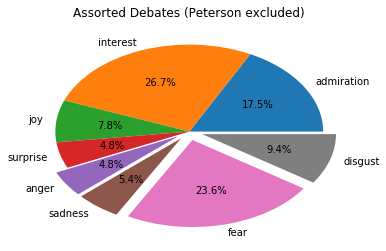

In [48]:
plt.pie(count_moodtags(comments.loc[(comments['Debate']==True) & (comments['JBP']==False)]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Assorted Debates (Peterson excluded)')
plt.show()

Oddly, fear is highly overrepresented. This is the first time we've seen such a major split inside a genre and video type, but I have a hunch that one of the debates in the dataset is skewing the sample:

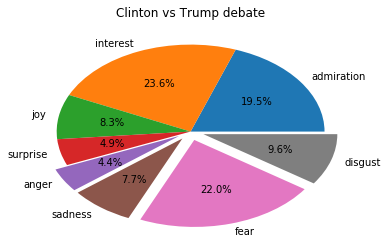

In [49]:
plt.pie(count_moodtags(comments.loc[(comments['Video Title']=='Clinton vs Trump Debate')]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Clinton vs Trump debate')
plt.show()

... or not. While this is strange, maybe there's a simple explanation.

One of Jordan Peterson's biggest claims to fame is his support of free speech and open debate. He has hours of video on his YouTube channel dedicated to the importance of vigorous debate. Remembering that, perhaps it shouldn't be so surprising that Peterson's audience actually seems _far more calm and comfortable_ around debates than other audiences.

Let's move onwards to the audience for lectures and talks, since we've found a divergence in mood among Peterson's audience.

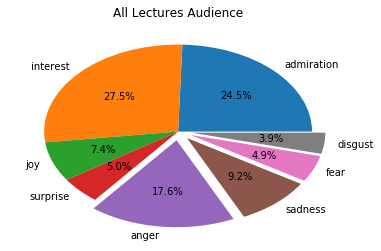

In [39]:
plt.pie(count_moodtags(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==False)]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('All Lectures Audience')
plt.show()

Another unexpected result: the lecture audiences seem far angrier than the debate audiences. Let's see if the general audience diverges from Peterson's here:

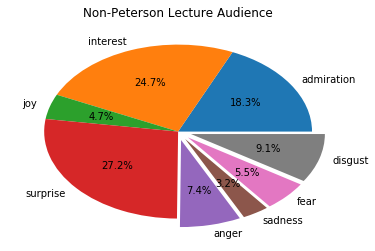

In [52]:
plt.pie(count_moodtags(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==False) & (comments['JBP']==False)]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Non-Peterson Lecture Audience')
plt.show()

Aha! We've found the angriest segment of Jordan Peterson's audience:

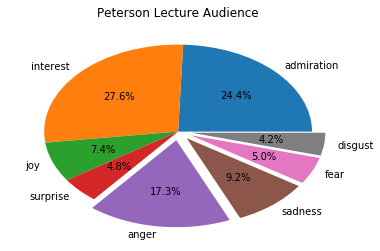

In [53]:
plt.pie(count_moodtags(comments.loc[(comments['Genre']=='Intellectual') & (comments['Debate']==False) & (comments['JBP']==True)]).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Peterson Lecture Audience')
plt.show()

Now, this is truly odd — these comments are on 60-120 minute university lectures about psychology and philosophy. Anger is still a minority mood, it's more than double the baseline for Peterson's overall audience. 

Though there , I do no

Given that the lectures only include the presenter, it will be hard to separate anger _towards_ the presenter best guess is that  As far as I can surmise, th

A few things to note before we consider this:
- This is a smaller group of comments; less people comment on lectures than debates
- 

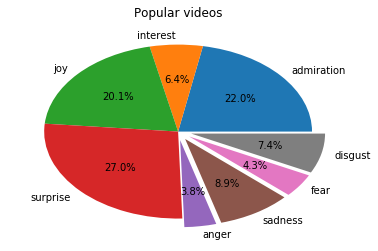

In [32]:
plt.pie(count_moodtags(popular_videos).values(), labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Popular videos')
plt.show()

In [33]:
wordcloud = WordCloud(background_color='white',
                          width=4000,
                          height=3000
                         ).generate_from_frequencies(debate_moods)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

NameError: name 'debate_moods' is not defined